In [ ]:
!pip install kmodes

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
!pip install matplotlib --upgrade

Restart Runtime After this 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import itertools
import pandas_profiling
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from kmodes import kmodes
from kmodes.kprototypes import KPrototypes
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<ipython-input-1-57ac84cdc3e8>:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [ ]:
applicationdf = pd.read_csv('application_data.csv')

In [ ]:
application_report = pandas_profiling.ProfileReport(applicationdf, minimal=True, \
                                                    title='Application dataframe profiling')

application_report.to_notebook_iframe()
application_report.to_file('application_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Defining some font setting funcitons for data visualization
content_font = {'fontsize':12,
                'color':'k', # k for black
                'family':'Trebuchet MS',
                'weight':'light',
                'style':'italic'}
title_font = {'fontsize':14,
              'color':'k', # k for black
              'family':'Trebuchet MS',
              'weight':'bold'}
note_font = {'size':12,
              'color':'r', # r for black
              'family':'Trebuchet MS',
              'weight':'bold'}

In [ ]:
# For numeric values, I will fill in missing values with -1.
# The reason for this is I want to distinguish between nan value and actual zero value
numeric_value_appl = applicationdf.select_dtypes(include=['int', 'float']).fillna(-1)
# For categorical value, I will fill missing value with 'None'
categorical_value_appl = applicationdf.select_dtypes(include=['object']).fillna('None')

application_cleaned = numeric_value_appl.join(categorical_value_appl)

print(application_cleaned.isnull().any().unique())  # [False]
# Capture 106 columns, which matched the number from the profiling report, and now all the numeric
# columns have no missing value.

print('The shape of cleaned dataset is {}'.format(application_cleaned.shape))
print('The shape of original dataset is {}'.format(applicationdf.shape))

[False]
The shape of cleaned dataset is (307511, 122)
The shape of original dataset is (307511, 122)


In [ ]:
# Make changes according to above descriptions.

application_cleaned.loc[application_cleaned['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = 0
application_cleaned.loc[application_cleaned['DAYS_EMPLOYED'] == 1, 'DAYS_EMPLOYED'] = 0
print(application_cleaned['DAYS_EMPLOYED'].max())  # now the maximum value is 0

application_cleaned.loc[application_cleaned['EMERGENCYSTATE_MODE'] == 'Yes','EMERGENCYSTATE_MODE'] = 1
application_cleaned.loc[application_cleaned['EMERGENCYSTATE_MODE'] == 'No', 'EMERGENCYSTATE_MODE'] = 0

print('Finish!')
print('The shape of cleaned dataset is {}'.format(application_cleaned.shape))


0
Finish!
The shape of cleaned dataset is (307511, 122)


In [ ]:
# Convert all the days count from negative to positive
column_df_appl = pd.DataFrame(numeric_value_appl.columns.values, columns=['col_name'])
column_df_appl['Contains_day'] = column_df_appl['col_name'].str.contains('days', case=False)
col_for_modification_appl = column_df_appl[column_df_appl['Contains_day'] == True]['col_name'].values

print('Here are columns need modification:')
print(col_for_modification_appl)

for col in col_for_modification_appl:
    application_cleaned.loc[:,col] = round(abs(application_cleaned.loc[:, col] // 365) , 2)
    name = col.replace('DAYS', 'YEARS')
    application_cleaned.rename(columns={col:name}, inplace=True)

print('The shape of cleaned dataset is {}'.format(application_cleaned.shape))

Here are columns need modification:
['DAYS_BIRTH' 'DAYS_EMPLOYED' 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH'
 'DAYS_LAST_PHONE_CHANGE']
The shape of cleaned dataset is (307511, 122)


In [ ]:
# make a copy of cleaned data for building 
train_df = application_cleaned.copy()
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to EMERGENCYSTATE_MODE
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


In [ ]:
# A function for binning numeric value with customized bin
def bin_numeric_column(feature, labels=[], bins=[], bin_num=5, add_label=False):
    if bins:
        if add_label:
            application_cleaned[feature] = pd.cut(application_cleaned[feature], bins=bins, labels=labels, 
                                                  include_lowest=True)
            print(application_cleaned[feature].head())
        else:
            application_cleaned[feature] = pd.cut(application_cleaned[feature], bins=bins, include_lowest=True)
            print(application_cleaned[feature].head())
    else:
        if add_label:
            application_cleaned[feature] = pd.cut(application_cleaned[feature], bins=bin_num, labels=labels,
                                                 include_lowest=True)
            print(application_cleaned[feature].head())
        else:
            application_cleaned[feature] = pd.cut(application_cleaned[feature], bins=bin_num, include_lowest=True)
            print(application_cleaned[feature].head())

# A Function to visualize the column value distribution via boxplot (to help us to customize bins according to the diagram)
def box_plot(feature, quantile=0):
    if (quantile > 0) & (quantile < 1):
        thersold = application_cleaned[feature].quantile(q=quantile)
        temp_data = application_cleaned.loc[application_cleaned[feature] < thersold, feature]
    else:
        temp_data = application_cleaned[feature]
        
    sns.boxplot(x=temp_data)
    print(temp_data.describe())

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64


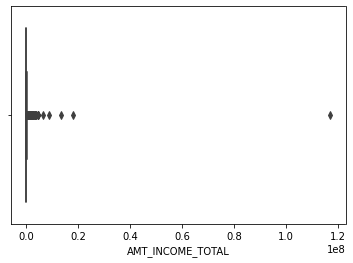

In [ ]:
# AMT_INCOME_TOTAL
box_plot("AMT_INCOME_TOTAL")

In [ ]:
bins_INCOME = [0, 50000, 100000, 150000, 200000, application_cleaned['AMT_INCOME_TOTAL'].max()]
labels_INCOME = ["Under 50k", "50k-100k", "100k-150k", "150k-200k", "200k+"]

In [ ]:
def client_labels_comparsion_chart(feature, figsize, rotate=False,vertical_oriented=False,label=True):
    if (application_cleaned[feature].dtype == 'object') | (application_cleaned[feature].dtype == 'category'):
        # Opt out of all the none values first
        filter_cond = ((application_cleaned[feature] == 'None') | (application_cleaned[feature] == 'XNA'))
        diagram_data = application_cleaned[~filter_cond]
        
        # Data preprocessing: calculate counts and defaulting rate of each categorical bin
        order = diagram_data[[feature, 'TARGET']].groupby(feature, as_index=False).mean(). \
        sort_values(by='TARGET',ascending=False)
        order['TARGET'] = round(order['TARGET'] * 100, 2)
        defaulter_count = diagram_data[[feature, 'TARGET']][diagram_data['TARGET'] == 1]. \
                          groupby(feature, as_index=False).count()
        order = pd.merge(order, defaulter_count, how='left', on=feature, suffixes=['_pct', '_count'])
        
        # value counts of selected feature
        feature_count = diagram_data[feature].value_counts()
        feature_count = feature_count.reset_index()
        
        # merge two datasets and print out the result
        result = pd.merge(order, feature_count, how='left', left_on=feature, right_on='index')
        result = result.drop('index', axis=1)
        result.columns = [feature, 'Defaulter_pct', 'Defaulter_count', 'Total_count']
         
        # plotting diagram
        # overall setting  
        if not vertical_oriented:
            fig, ax =plt.subplots(1,2,constrained_layout=True, figsize=figsize)
        else:
            fig, ax =plt.subplots(2,1,constrained_layout=True, figsize=figsize)
        
        # Picture 1: showing counts and defaulter percentage of each categorical bin
        axpic1 = sns.countplot(x=feature, hue="TARGET", data=diagram_data, order=order[feature],
                               palette=['g','r'], ax=ax[0])
        axpic1_2 = ax[0].twinx()
        axpic1_2.plot(order['TARGET_pct'].values, color='orange', marker='o')
        axpic1_2.set_ylabel("Defaulter percentage",**content_font)
        axpic1.set_xlabel(feature, **content_font)
        axpic1.set_ylabel("Value counts", **content_font)
        axpic1.set_title('Counts and defaulter % of each categorical bin in {}'.format(feature), **title_font)
        axpic1.legend(['Repayer', 'Defaulter'], loc='upper right')
        
        # Picture 2: showing value distribution of selected feature
        feature_count = diagram_data[feature].value_counts()
        axpic2 = sns.countplot(x=feature, data=diagram_data, order=feature_count.index.values,
                               palette=['b'], ax=ax[1])     
        axpic2.set_title("Value distribution of {}".format(feature), **title_font)
        axpic2.set_xlabel(feature, **content_font)
        axpic2.set_ylabel("Value counts", **content_font)
        
        # Add Label?
        if label:
            # label for picture 1
            for x, row in order.iterrows():
                pct = row['TARGET_pct']
                pct_str = '{}%'.format(row['TARGET_pct'])
                count = row['TARGET_count']
                axpic1_2.annotate(r'%s' % pct_str,xy=(x, pct),xytext=(x, pct), textcoords="offset points",
                                  ha="center", color='r', size=12, family='Trebuchet MS', weight='bold')
            # label for picture 2
            pic2_labels = [v.get_height() for v in axpic2.containers[0]]
            axpic2.bar_label(axpic2.containers[0], labels=pic2_labels, label_type='edge',
                             size=12, family='Trebuchet MS', weight='bold')
            
        # Rotate label?:
        if rotate:
            axpic1.set_xticks(axpic1.get_xticks(), axpic1.get_xticklabels(), rotation=45, ha='right')
            axpic2.set_xticks(axpic2.get_xticks(), axpic2.get_xticklabels(), rotation=45, ha='right')  
            
        plt.show()
        
        # Print out the result
        print("Here are the tatistical results:")
        print(result)
             
    else:
        print(r'Please sepecify a object type column')

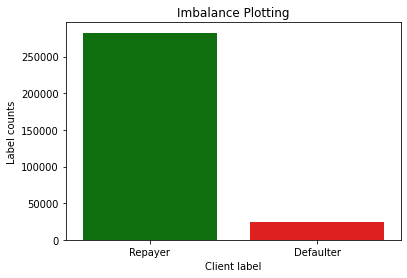

Defaulting rate: 8.07 %


In [ ]:
# perform the imblance analysis
Imbalance = application_cleaned["TARGET"].value_counts().reset_index()
plt.figure(figsize=(6,4))
x= ['Repayer','Defaulter']
sns.barplot(x,"TARGET",data=Imbalance,palette=['g','r'])
plt.xlabel("Client label")
plt.ylabel("Label counts")
plt.title("Imbalance Plotting")
plt.show()

# print out the defaulting rate:
defaulter_rate = round(Imbalance.iloc[1]["TARGET"]/application_cleaned.shape[0]*100, 2)
print('Defaulting rate: {} %'.format(defaulter_rate))

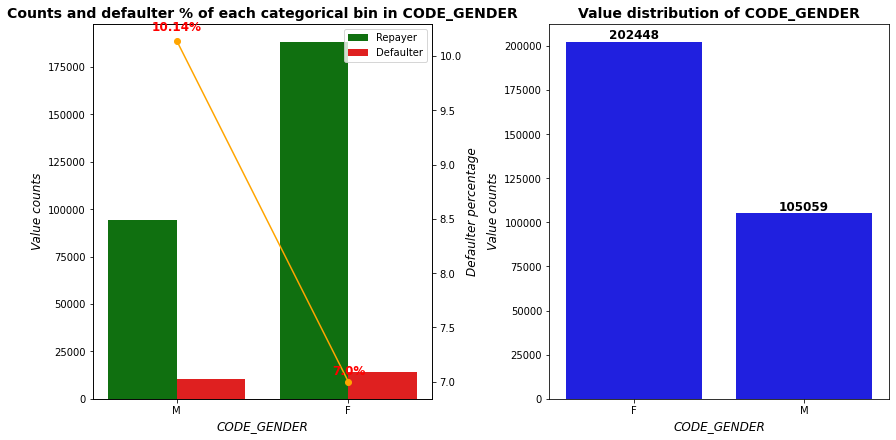

Here are the tatistical results:
  CODE_GENDER  Defaulter_pct  Defaulter_count  Total_count
0           M          10.14            10655       105059
1           F           7.00            14170       202448


In [ ]:
# Client Gender.
client_labels_comparsion_chart(feature='CODE_GENDER',figsize=(12,6))

0        200k+
1        200k+
2     50k-100k
3    100k-150k
4    100k-150k
Name: AMT_INCOME_TOTAL, dtype: category
Categories (5, object): ['Under 50k' < '50k-100k' < '100k-150k' < '150k-200k' < '200k+']


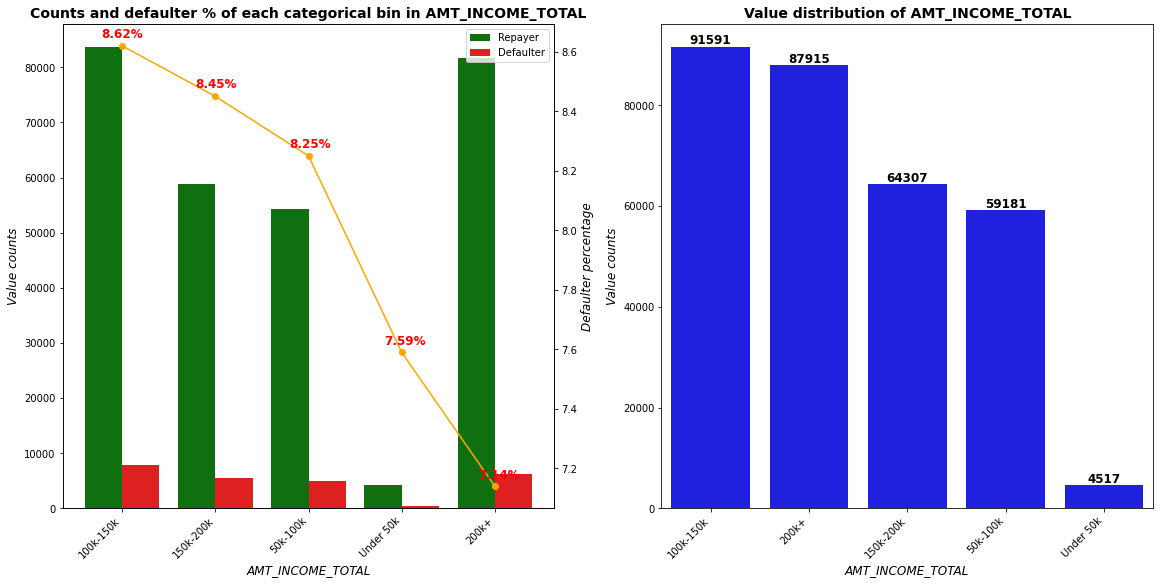

Here are the tatistical results:
  AMT_INCOME_TOTAL  Defaulter_pct  Defaulter_count  Total_count
0        100k-150k           8.62             7894        91591
1        150k-200k           8.45             5432        64307
2         50k-100k           8.25             4882        59181
3        Under 50k           7.59              343         4517
4            200k+           7.14             6274        87915


In [ ]:
# AMT_INCOME_TOTAL
bin_numeric_column('AMT_INCOME_TOTAL', labels=labels_INCOME, bins=bins_INCOME, bin_num=5, add_label=True)
client_labels_comparsion_chart(feature='AMT_INCOME_TOTAL',figsize=(16,8),rotate=True)

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64
0     250k-500k
1       1m-1.5m
2    Under 250k
3     250k-500k
4     500k-750k
Name: AMT_CREDIT, dtype: category
Categories (7, object): ['Under 250k' < '250k-500k' < '500k-750k' < '750k-1m' < '1m-1.5m' < '1.5m-2m' <
                         '2m+']


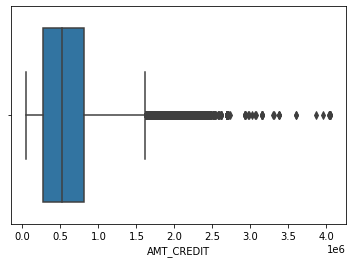

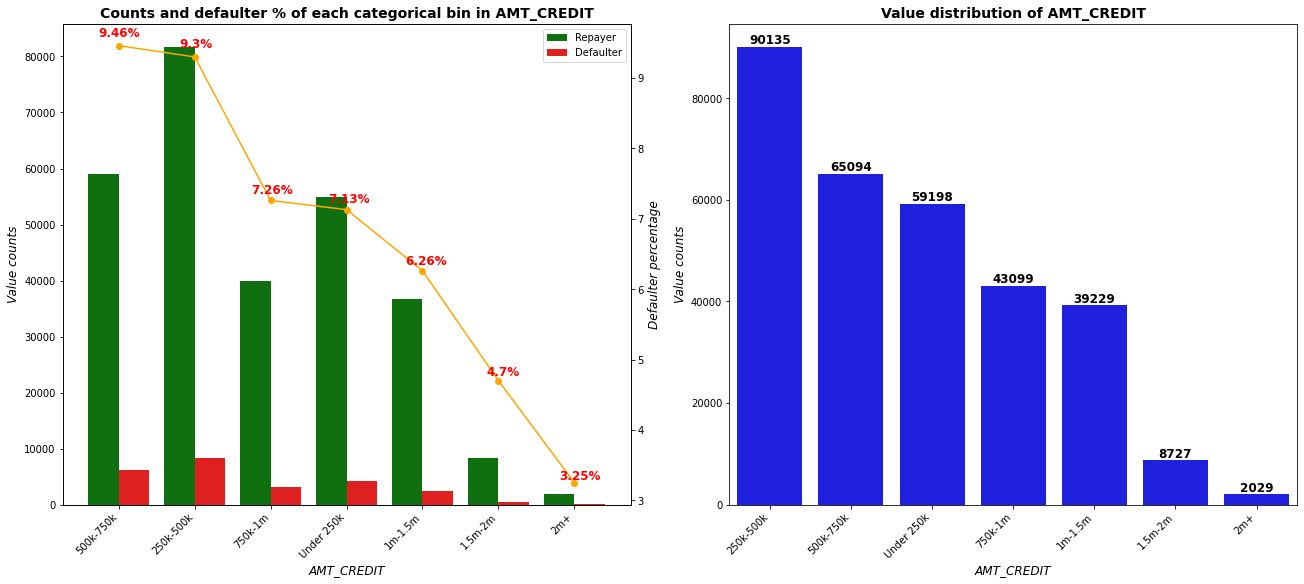

Here are the tatistical results:
   AMT_CREDIT  Defaulter_pct  Defaulter_count  Total_count
0   500k-750k           9.46             6159        65094
1   250k-500k           9.30             8385        90135
2     750k-1m           7.26             3129        43099
3  Under 250k           7.13             4220        59198
4     1m-1.5m           6.26             2456        39229
5     1.5m-2m           4.70              410         8727
6         2m+           3.25               66         2029


In [ ]:
# AMT_CREDIT
box_plot("AMT_CREDIT")
bins_CREDIT = [0, 250000, 500000, 750000, 1000000, 1500000, 2000000, application_cleaned['AMT_CREDIT'].max()]
labels_CREDIT = ["Under 250k", "250k-500k", "500k-750k", "750k-1m","1m-1.5m", "1.5m-2m", "2m+"]
bin_numeric_column('AMT_CREDIT', labels=labels_CREDIT, bins=bins_CREDIT, bin_num=len(labels_CREDIT), add_label=True)
client_labels_comparsion_chart(feature='AMT_CREDIT',figsize=(18,8),rotate=True)

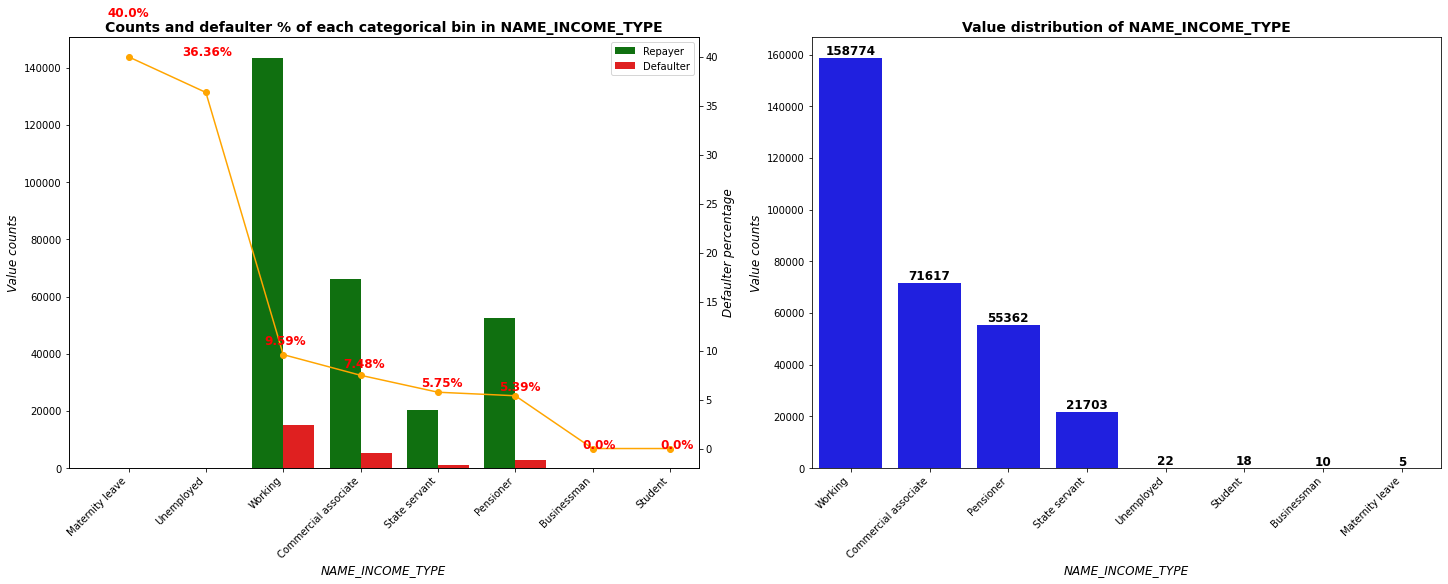

Here are the tatistical results:
       NAME_INCOME_TYPE  Defaulter_pct  Defaulter_count  Total_count
0       Maternity leave          40.00              2.0            5
1            Unemployed          36.36              8.0           22
2               Working           9.59          15224.0       158774
3  Commercial associate           7.48           5360.0        71617
4         State servant           5.75           1249.0        21703
5             Pensioner           5.39           2982.0        55362
6           Businessman           0.00              NaN           10
7               Student           0.00              NaN           18


In [ ]:
# NAME_INCOME_TYPE
client_labels_comparsion_chart(feature='NAME_INCOME_TYPE',figsize=(20,8),rotate=True)

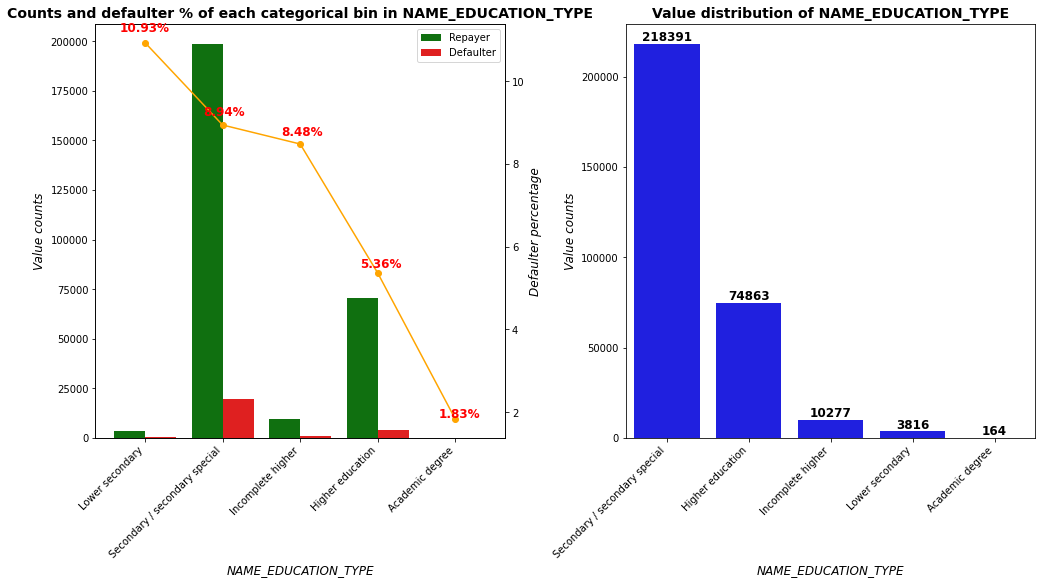

Here are the tatistical results:
             NAME_EDUCATION_TYPE  Defaulter_pct  Defaulter_count  Total_count
0                Lower secondary          10.93              417         3816
1  Secondary / secondary special           8.94            19524       218391
2              Incomplete higher           8.48              872        10277
3               Higher education           5.36             4009        74863
4                Academic degree           1.83                3          164


In [ ]:
# NAME_EDUCATION_TYPE
client_labels_comparsion_chart(feature='NAME_EDUCATION_TYPE',figsize=(14,8),rotate=True)

count    307511.000000
mean         44.433090
std          11.954493
min          21.000000
25%          35.000000
50%          44.000000
75%          54.000000
max          70.000000
Name: YEARS_BIRTH, dtype: float64
0    Under 30
1       40-50
2       50-60
3       50-60
4       50-60
Name: YEARS_BIRTH, dtype: category
Categories (5, object): ['Under 30' < '30-40' < '40-50' < '50-60' < '60+']


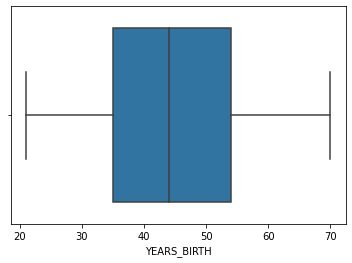

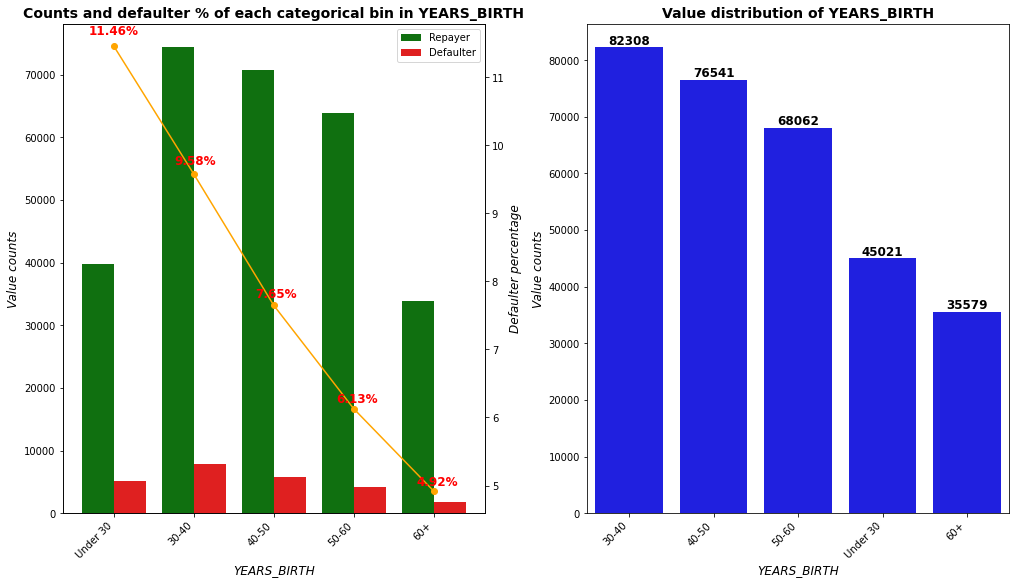

Here are the tatistical results:
  YEARS_BIRTH  Defaulter_pct  Defaulter_count  Total_count
0    Under 30          11.46             5158        45021
1       30-40           9.58             7888        82308
2       40-50           7.65             5856        76541
3       50-60           6.13             4172        68062
4         60+           4.92             1751        35579


In [ ]:
# YEARS_BIRTH
box_plot("YEARS_BIRTH")
bins_AGE = [0, 30, 40, 50, 60, application_cleaned['YEARS_BIRTH'].max()]
labels_AGE = ['Under 30', '30-40', '40-50', '50-60', '60+']
bin_numeric_column('YEARS_BIRTH', labels=labels_AGE, bins=bins_AGE, bin_num=len(labels_AGE), add_label=True)
client_labels_comparsion_chart(feature='YEARS_BIRTH',figsize=(14,8),rotate=True)

count    307511.000000
mean          5.767865
std           6.407564
min           0.000000
25%           1.000000
50%           4.000000
75%           8.000000
max          50.000000
Name: YEARS_EMPLOYED, dtype: float64
0    Less than 2 years
1            2-5 years
2    Less than 2 years
3           5-10 years
4           5-10 years
Name: YEARS_EMPLOYED, dtype: category
Categories (5, object): ['Less than 2 years' < '2-5 years' < '5-10 years' < '10-15 years' < '15 years+']


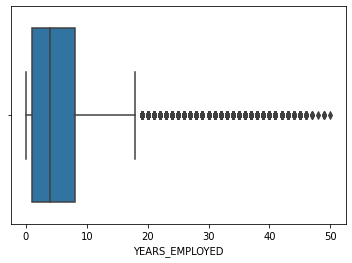

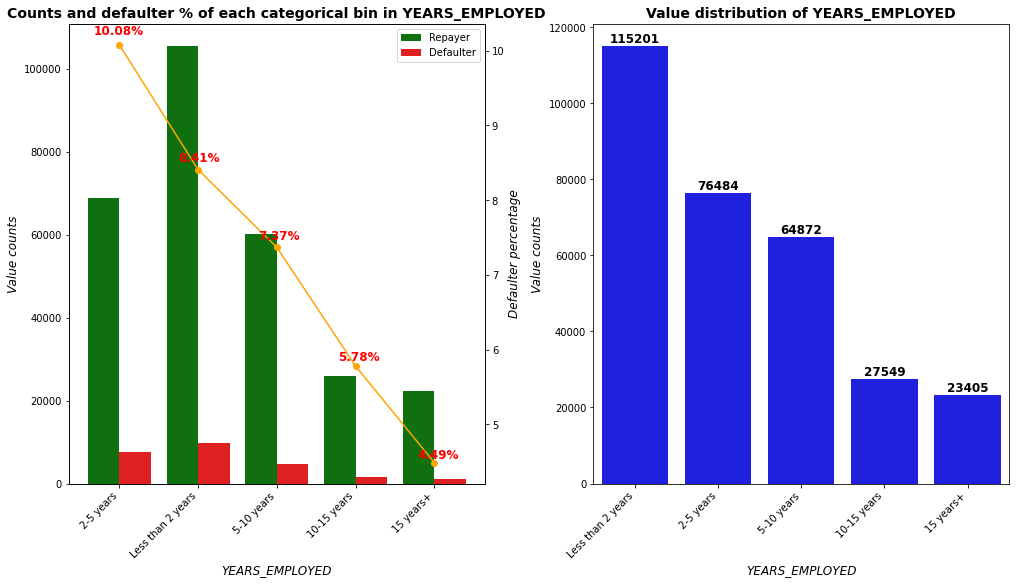

Here are the tatistical results:
      YEARS_EMPLOYED  Defaulter_pct  Defaulter_count  Total_count
0          2-5 years          10.08             7708        76484
1  Less than 2 years           8.41             9692       115201
2         5-10 years           7.37             4782        64872
3        10-15 years           5.78             1591        27549
4          15 years+           4.49             1052        23405


In [ ]:
# YEARS_EMPLOYED
box_plot("YEARS_EMPLOYED")
bins_EMPLOYED = [0, 2, 5, 10, 15, application_cleaned['YEARS_EMPLOYED'].max()]
labels_EMPLOYED = ['Less than 2 years', '2-5 years', '5-10 years', '10-15 years', '15 years+']
bin_numeric_column('YEARS_EMPLOYED', labels=labels_EMPLOYED, bins=bins_EMPLOYED, bin_num=len(labels_EMPLOYED), 
                   add_label=True)
client_labels_comparsion_chart(feature='YEARS_EMPLOYED',figsize=(14,8),rotate=True)

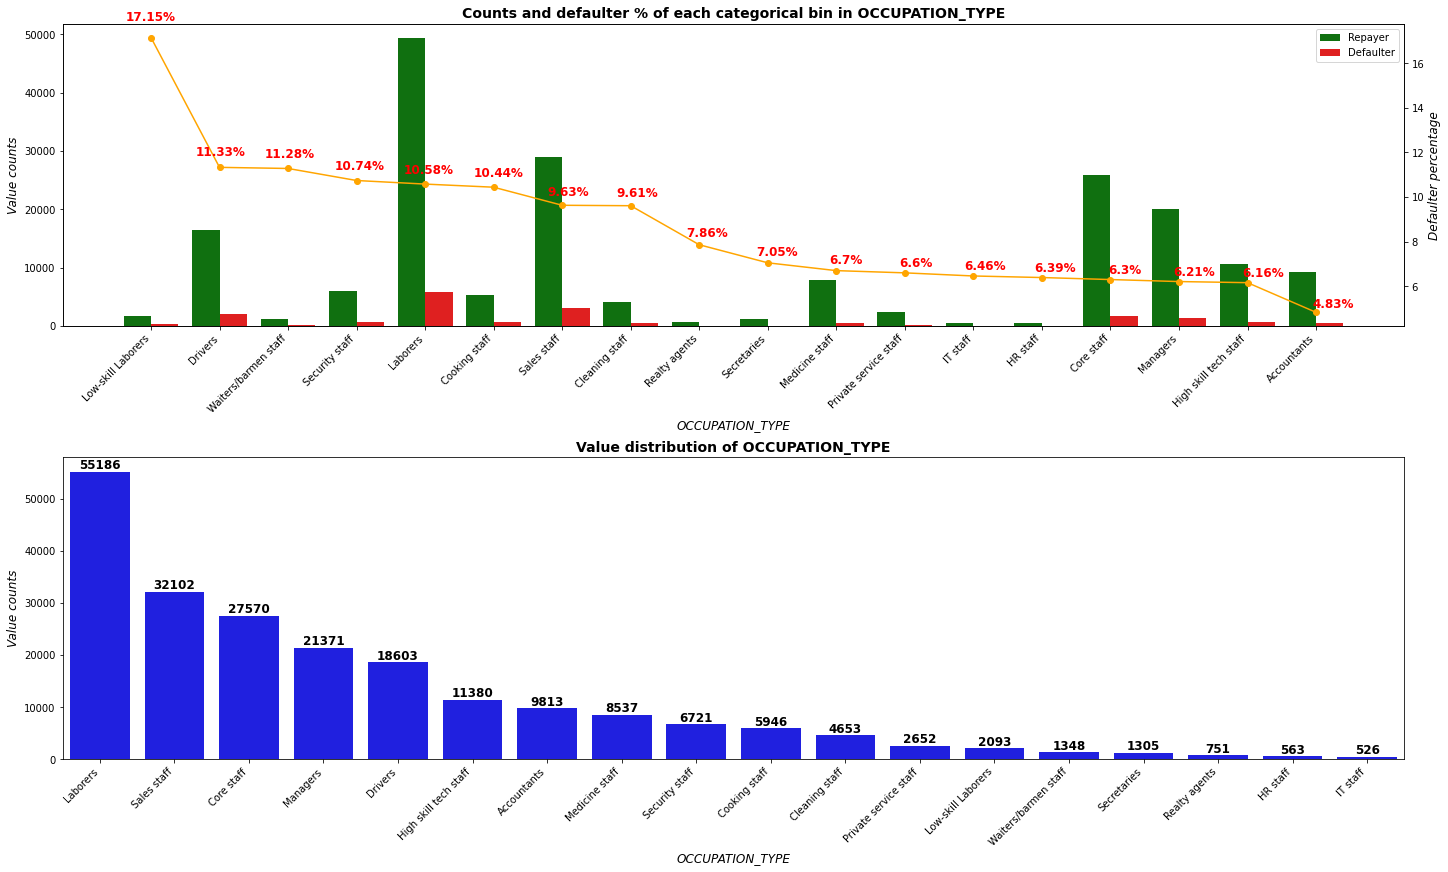

Here are the tatistical results:
          OCCUPATION_TYPE  Defaulter_pct  Defaulter_count  Total_count
0      Low-skill Laborers          17.15              359         2093
1                 Drivers          11.33             2107        18603
2    Waiters/barmen staff          11.28              152         1348
3          Security staff          10.74              722         6721
4                Laborers          10.58             5838        55186
5           Cooking staff          10.44              621         5946
6             Sales staff           9.63             3092        32102
7          Cleaning staff           9.61              447         4653
8           Realty agents           7.86               59          751
9             Secretaries           7.05               92         1305
10         Medicine staff           6.70              572         8537
11  Private service staff           6.60              175         2652
12               IT staff           6.46    

In [ ]:
# OCCUPATION_TYPE
client_labels_comparsion_chart(feature='OCCUPATION_TYPE',figsize=(20,12),rotate=True, vertical_oriented=True)

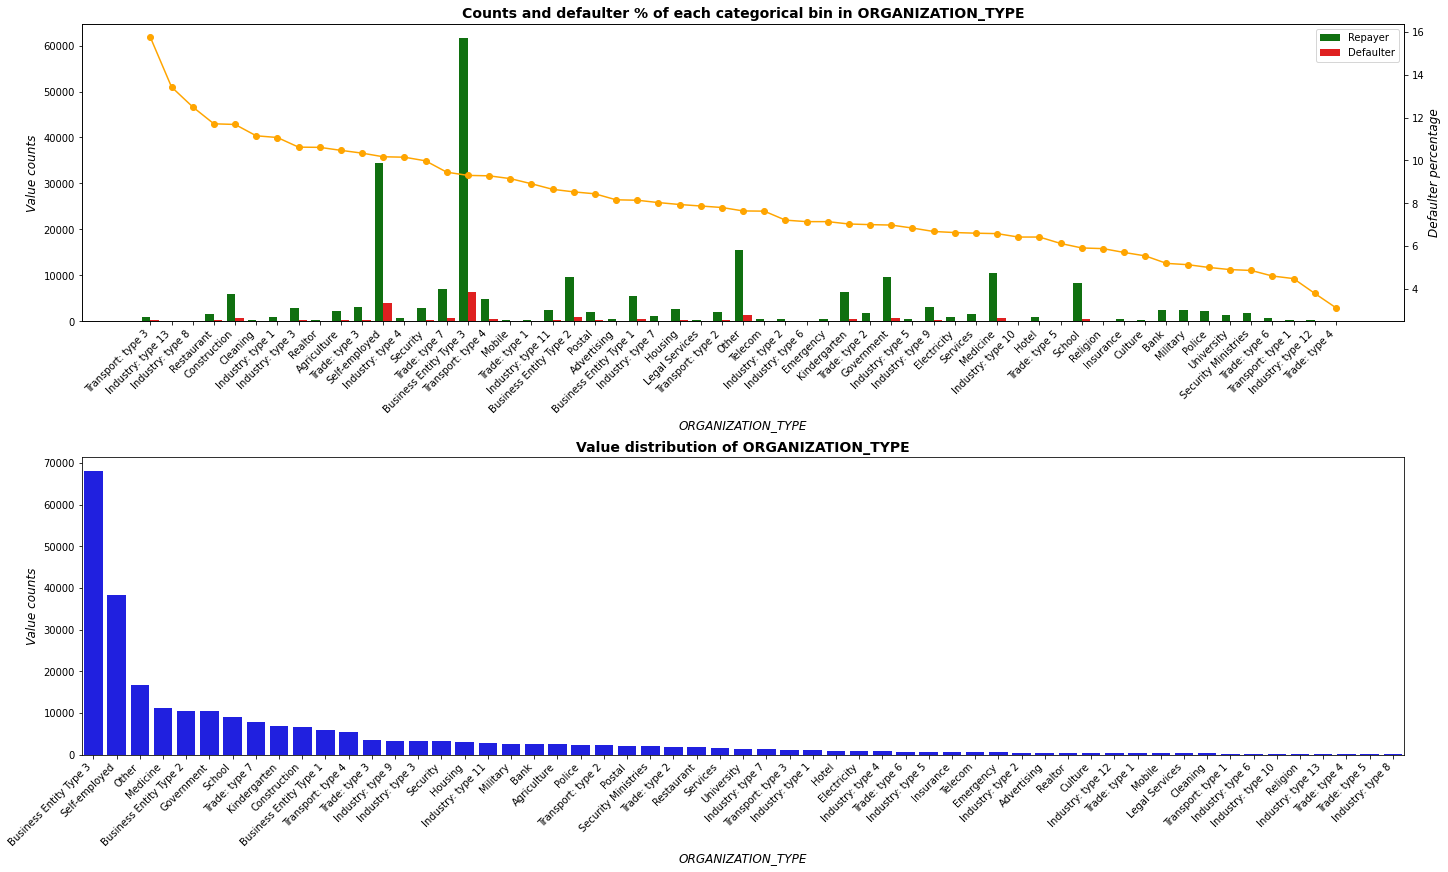

Here are the tatistical results:
         ORGANIZATION_TYPE  Defaulter_pct  Defaulter_count  Total_count
0        Transport: type 3          15.75              187         1187
1        Industry: type 13          13.43                9           67
2         Industry: type 8          12.50                3           24
3               Restaurant          11.71              212         1811
4             Construction          11.68              785         6721
5                 Cleaning          11.15               29          260
6         Industry: type 1          11.07              115         1039
7         Industry: type 3          10.62              348         3278
8                  Realtor          10.61               42          396
9              Agriculture          10.47              257         2454
10           Trade: type 3          10.34              361         3492
11           Self-employed          10.17             3908        38412
12        Industry: type 4     

In [ ]:
# ORGANIZATION_TYPE
client_labels_comparsion_chart(feature='ORGANIZATION_TYPE',figsize=(20,12),rotate=True, vertical_oriented=True,
                               label=False)

count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64
0    No child
1    No child
2    No child
3    No child
4    No child
Name: CNT_CHILDREN, dtype: category
Categories (7, object): ['No child' < '1 child' < '2 children' < '3 children' < '4 children' <
                         '5 children' < '5+ children']


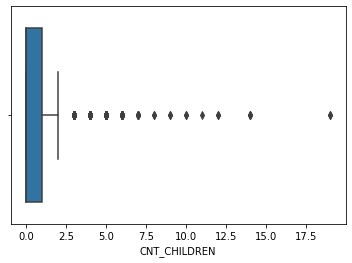

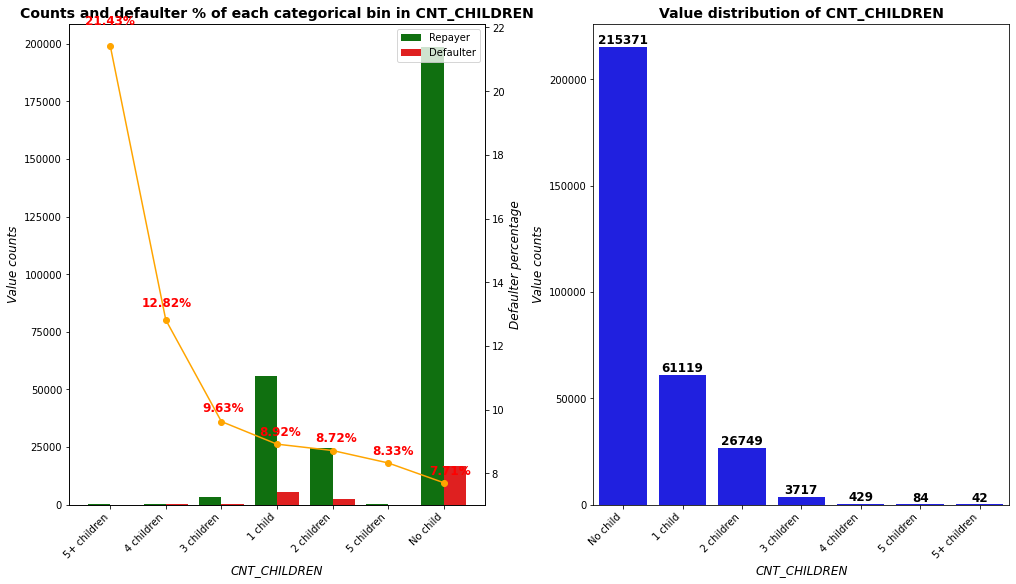

Here are the tatistical results:
  CNT_CHILDREN  Defaulter_pct  Defaulter_count  Total_count
0  5+ children          21.43                9           42
1   4 children          12.82               55          429
2   3 children           9.63              358         3717
3      1 child           8.92             5454        61119
4   2 children           8.72             2333        26749
5   5 children           8.33                7           84
6     No child           7.71            16609       215371


In [ ]:
# CNT_CHILDREN
# My function only accepts 'category' or 'object' type of data, so we need to change the data type of this column to 
# 'string'
box_plot("CNT_CHILDREN")
bins_CHILDREN = [-1, 0, 1, 2, 3, 4, 5, application_cleaned['CNT_CHILDREN'].max()]
labels_CHILDREN = ['No child', '1 child', '2 children', '3 children', '4 children', '5 children', '5+ children']
bin_numeric_column('CNT_CHILDREN', labels=labels_CHILDREN, bins=bins_CHILDREN, bin_num=len(labels_CHILDREN), 
                   add_label=True)
client_labels_comparsion_chart(feature='CNT_CHILDREN',figsize=(14,8),rotate=True)

# application_cleaned['CNT_CHILDREN'] = application_cleaned['CNT_CHILDREN'].astype('object')
# client_labels_comparsion_chart(feature='CNT_CHILDREN',figsize=(14,8), vertical_oriented=True)

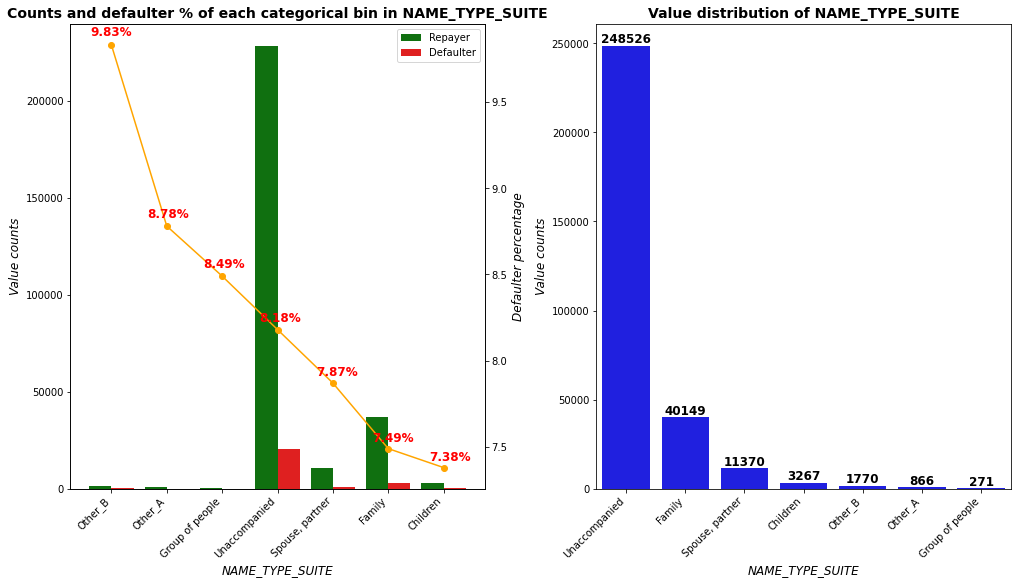

Here are the tatistical results:
   NAME_TYPE_SUITE  Defaulter_pct  Defaulter_count  Total_count
0          Other_B           9.83              174         1770
1          Other_A           8.78               76          866
2  Group of people           8.49               23          271
3    Unaccompanied           8.18            20337       248526
4  Spouse, partner           7.87              895        11370
5           Family           7.49             3009        40149
6         Children           7.38              241         3267


In [ ]:
# NAME_TYPE_SUITE
client_labels_comparsion_chart(feature='NAME_TYPE_SUITE',figsize=(14,8), rotate=True)

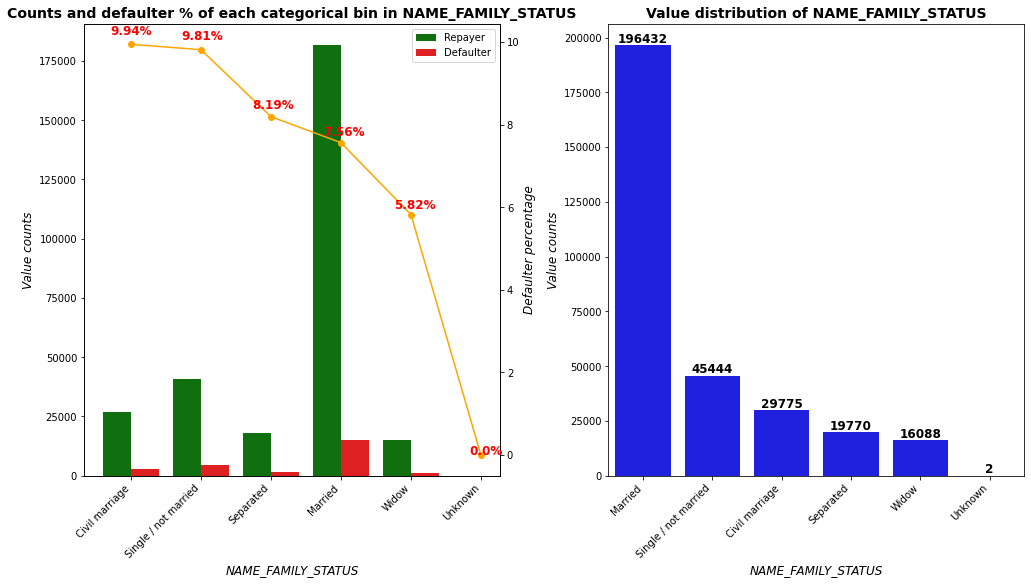

Here are the tatistical results:
     NAME_FAMILY_STATUS  Defaulter_pct  Defaulter_count  Total_count
0        Civil marriage           9.94           2961.0        29775
1  Single / not married           9.81           4457.0        45444
2             Separated           8.19           1620.0        19770
3               Married           7.56          14850.0       196432
4                 Widow           5.82            937.0        16088
5               Unknown           0.00              NaN            2


In [ ]:
# NAME_FAMILY_STATUS
client_labels_comparsion_chart(feature='NAME_FAMILY_STATUS',figsize=(14,8), rotate=True)

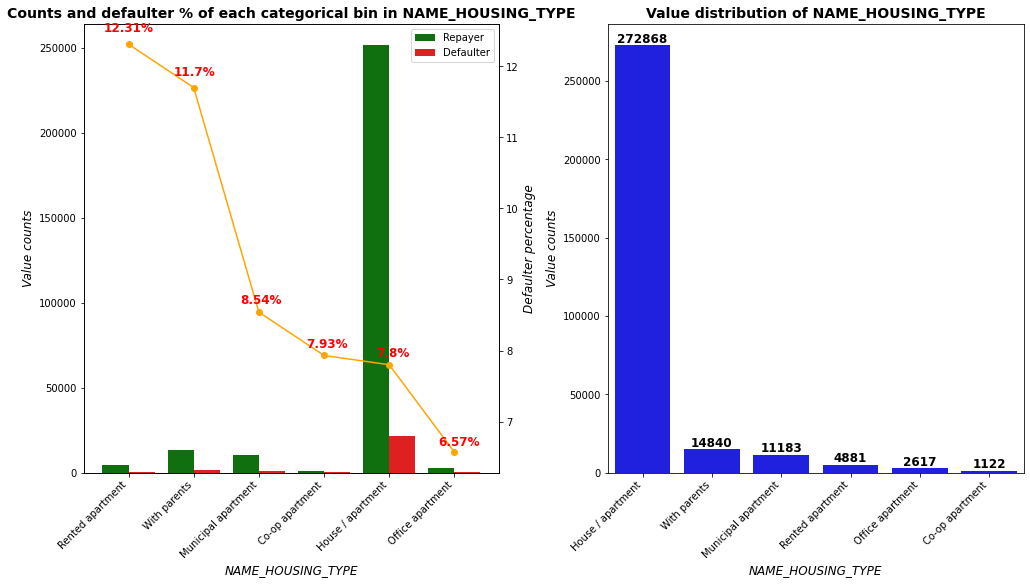

Here are the tatistical results:
     NAME_HOUSING_TYPE  Defaulter_pct  Defaulter_count  Total_count
0     Rented apartment          12.31              601         4881
1         With parents          11.70             1736        14840
2  Municipal apartment           8.54              955        11183
3      Co-op apartment           7.93               89         1122
4    House / apartment           7.80            21272       272868
5     Office apartment           6.57              172         2617


In [ ]:
# NAME_HOUSING_TYPE
client_labels_comparsion_chart(feature='NAME_HOUSING_TYPE',figsize=(14,8), rotate=True)

count    307511.000000
mean          2.152645
std           0.910714
min          -1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64
0     1 member
1    2 members
2     1 member
3    2 members
4     1 member
Name: CNT_FAM_MEMBERS, dtype: category
Categories (7, object): ['Unknown' < '1 member' < '2 members' < '3 members' < '4 members' <
                         '5 members' < '5+ members']


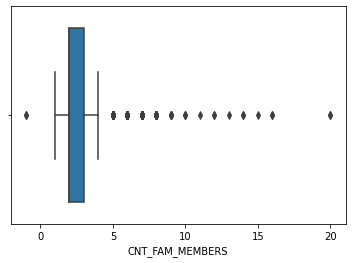

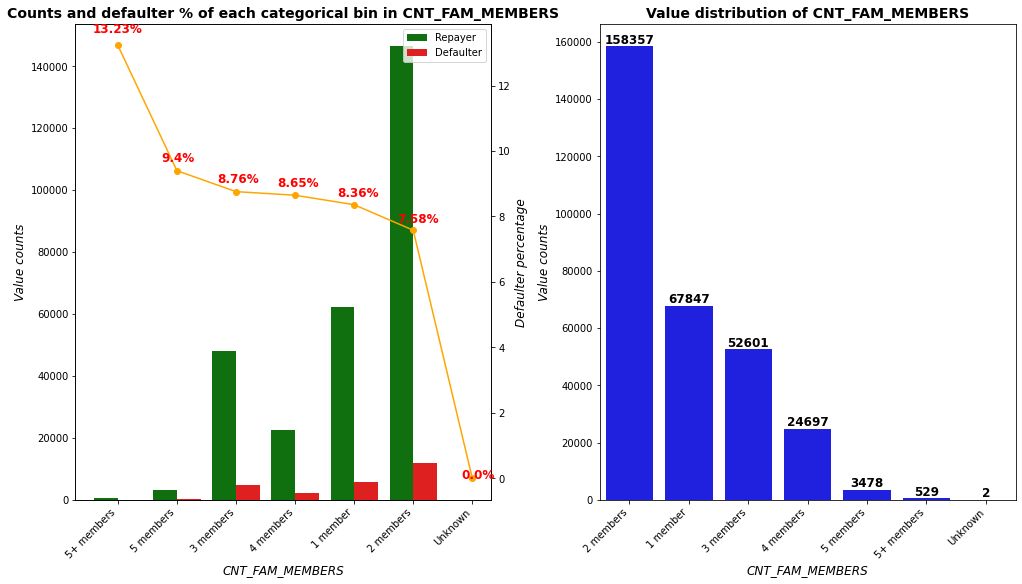

Here are the tatistical results:
  CNT_FAM_MEMBERS  Defaulter_pct  Defaulter_count  Total_count
0      5+ members          13.23               70          529
1       5 members           9.40              327         3478
2       3 members           8.76             4608        52601
3       4 members           8.65             2136        24697
4        1 member           8.36             5675        67847
5       2 members           7.58            12009       158357
6         Unknown           0.00                0            2


In [ ]:
# CNT_FAM_MEMBERS
box_plot("CNT_FAM_MEMBERS")
bins_MEMBERS = [-1, 0, 1, 2, 3, 4, 5, application_cleaned['CNT_FAM_MEMBERS'].max()]
labels_MEMBERS = ['Unknown', '1 member', '2 members', '3 members', '4 members', '5 members', '5+ members']
bin_numeric_column('CNT_FAM_MEMBERS', labels=labels_MEMBERS, bins=bins_MEMBERS, bin_num=len(labels_MEMBERS), 
                   add_label=True)
client_labels_comparsion_chart(feature='CNT_FAM_MEMBERS',figsize=(14,8),rotate=True)

# application_cleaned['CNT_FAM_MEMBERS'] = application_cleaned['CNT_FAM_MEMBERS'].astype('object')
# client_labels_comparsion_chart(feature='CNT_FAM_MEMBERS',figsize=(14,8), vertical_oriented=True)

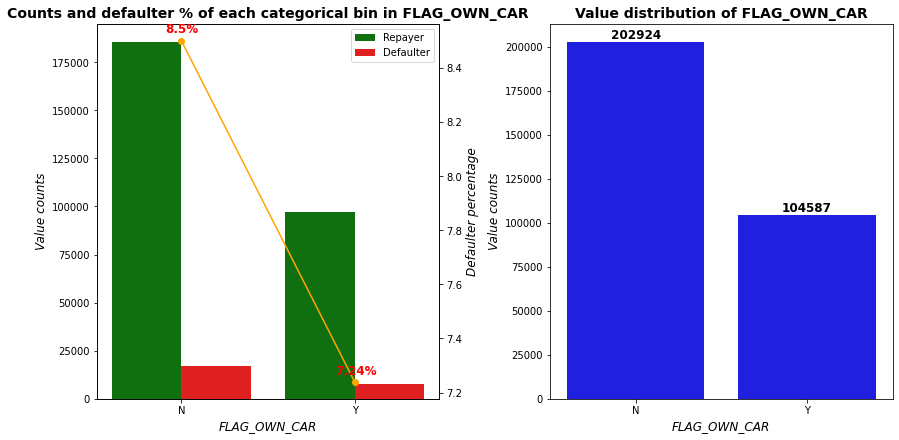

Here are the tatistical results:
  FLAG_OWN_CAR  Defaulter_pct  Defaulter_count  Total_count
0            N           8.50            17249       202924
1            Y           7.24             7576       104587


In [ ]:
# FLAG_OWN_CAR
client_labels_comparsion_chart(feature='FLAG_OWN_CAR',figsize=(12,6))

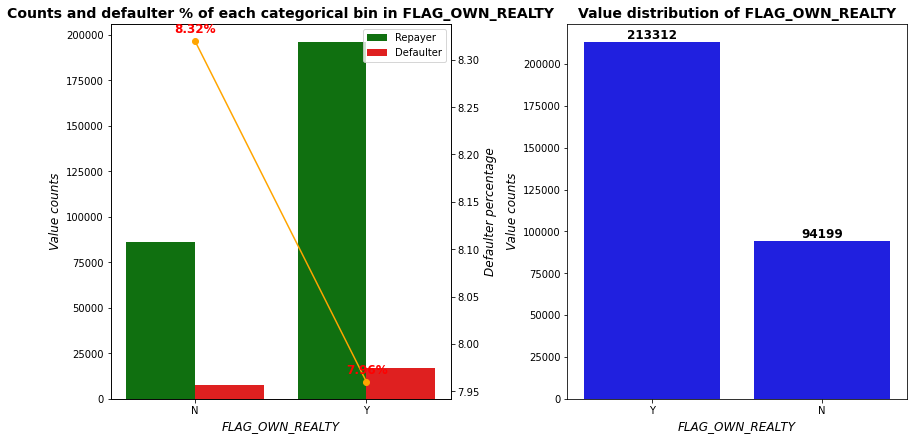

Here are the tatistical results:
  FLAG_OWN_REALTY  Defaulter_pct  Defaulter_count  Total_count
0               N           8.32             7842        94199
1               Y           7.96            16983       213312


In [ ]:
# FLAG_OWN_REALTY
client_labels_comparsion_chart(feature='FLAG_OWN_REALTY',figsize=(12,6))

count    307511.000000
mean          3.441971
std           9.317162
min          -1.000000
25%          -1.000000
50%          -1.000000
75%           5.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64
0          NaN
1          NaN
2    15 years+
3          NaN
4          NaN
Name: OWN_CAR_AGE, dtype: category
Categories (5, object): ['Less than 3 years' < '3-6 years' < '6-10 years' < '10-15 years' < '15 years+']


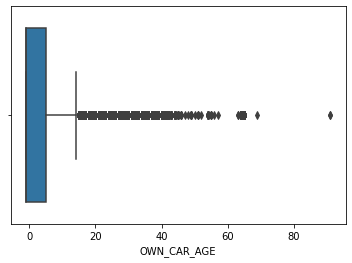

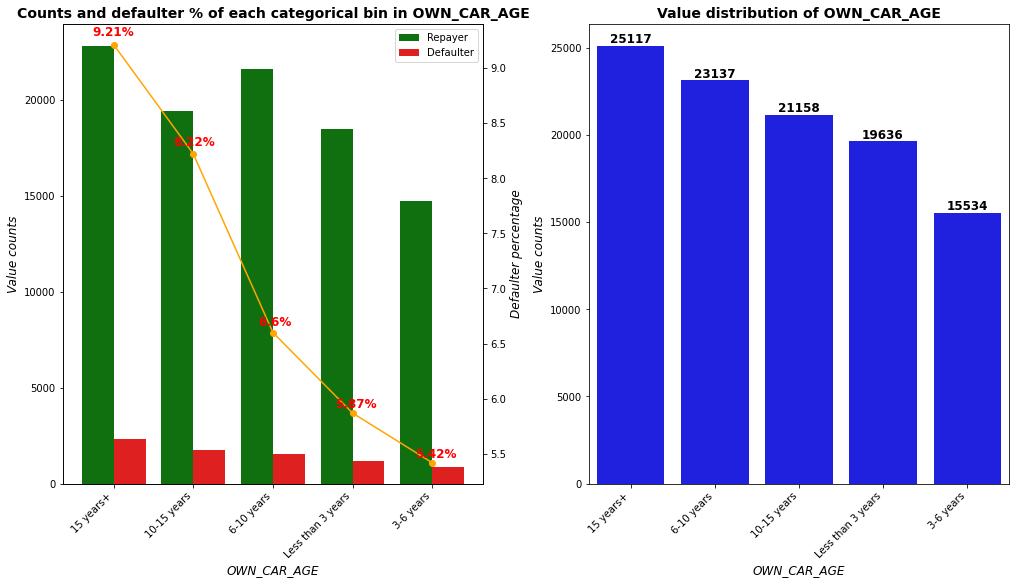

Here are the tatistical results:
         OWN_CAR_AGE  Defaulter_pct  Defaulter_count  Total_count
0          15 years+           9.21             2314        25117
1        10-15 years           8.22             1740        21158
2         6-10 years           6.60             1528        23137
3  Less than 3 years           5.87             1152        19636
4          3-6 years           5.42              842        15534


In [ ]:
# OWN_CAR_AGE
box_plot("OWN_CAR_AGE")
bins_CARAGE = [0, 3, 6, 10, 15, application_cleaned['OWN_CAR_AGE'].max()]
labels_CARAGE = ['Less than 3 years', '3-6 years', '6-10 years', '10-15 years', '15 years+']
bin_numeric_column('OWN_CAR_AGE', labels=labels_CARAGE, bins=bins_CARAGE, bin_num=len(labels_CARAGE), 
                   add_label=True)
client_labels_comparsion_chart(feature='OWN_CAR_AGE',figsize=(14,8),rotate=True)

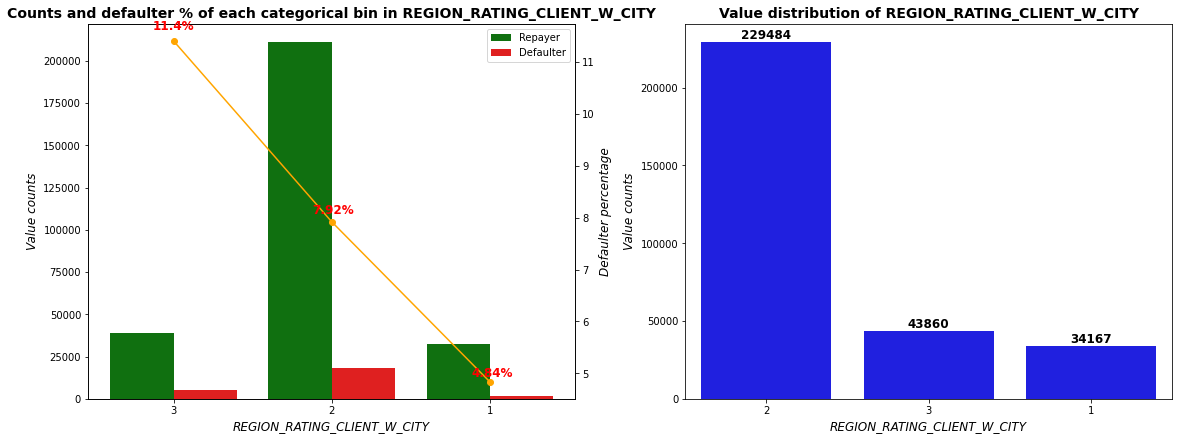

Here are the tatistical results:
   REGION_RATING_CLIENT_W_CITY  Defaulter_pct  Defaulter_count  Total_count
0                            3          11.40             5001        43860
1                            2           7.92            18170       229484
2                            1           4.84             1654        34167


In [ ]:
# REGION_RATING_CLIENT_W_CITY
application_cleaned['REGION_RATING_CLIENT_W_CITY'] = application_cleaned['REGION_RATING_CLIENT_W_CITY'].astype('object')
client_labels_comparsion_chart(feature='REGION_RATING_CLIENT_W_CITY',figsize=(16,6))

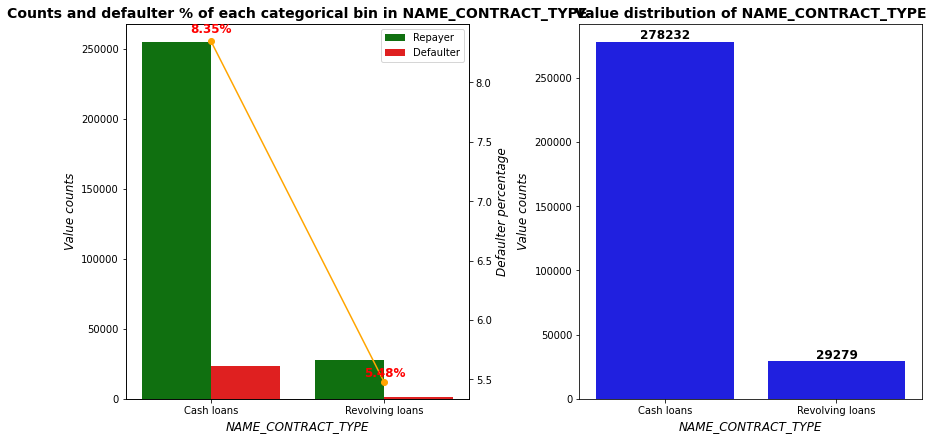

Here are the tatistical results:
  NAME_CONTRACT_TYPE  Defaulter_pct  Defaulter_count  Total_count
0         Cash loans           8.35            23221       278232
1    Revolving loans           5.48             1604        29279


In [ ]:
# NAME_CONTRACT_TYPE
client_labels_comparsion_chart(feature='NAME_CONTRACT_TYPE',figsize=(12,6))

count    307511.000000
mean      27107.516012
std       14494.443830
min          -1.000000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64
0           20-25k
1             35k+
2    Less than 10k
3          25k-30k
4           20-25k
Name: AMT_ANNUITY, dtype: category
Categories (6, object): ['Less than 10k' < '10k-20k' < '20-25k' < '25k-30k' < '30k-35k' < '35k+']


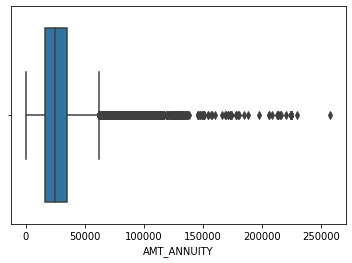

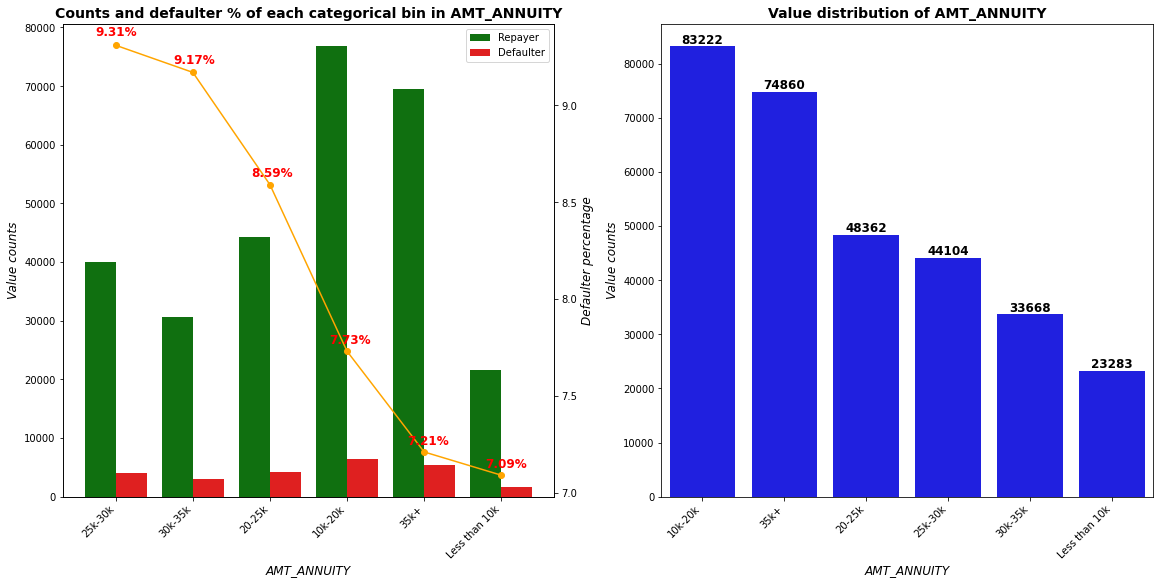

Here are the tatistical results:
     AMT_ANNUITY  Defaulter_pct  Defaulter_count  Total_count
0        25k-30k           9.31             4105        44104
1        30k-35k           9.17             3089        33668
2         20-25k           8.59             4153        48362
3        10k-20k           7.73             6434        83222
4           35k+           7.21             5394        74860
5  Less than 10k           7.09             1650        23283


In [ ]:
# AMT_ANNUITY
box_plot("AMT_ANNUITY")
bins_ANNUITY = [0, 10000, 20000, 25000, 30000, 35000, application_cleaned['AMT_ANNUITY'].max()]
labels_ANNUITY = ['Less than 10k', '10k-20k', '20-25k', '25k-30k', '30k-35k', '35k+']
bin_numeric_column('AMT_ANNUITY', labels=labels_ANNUITY, bins=bins_ANNUITY, bin_num=len(labels_ANNUITY), 
                   add_label=True)
client_labels_comparsion_chart(feature='AMT_ANNUITY',figsize=(16,8),rotate=True)

count    3.075110e+05
mean     5.379095e+05
std      3.696338e+05
min     -1.000000e+00
25%      2.385000e+05
50%      4.500000e+05
75%      6.795000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64
0         200k-400k
1             800k+
2    Less than 200k
3         200k-400k
4         400k-600k
Name: AMT_GOODS_PRICE, dtype: category
Categories (5, object): ['Less than 200k' < '200k-400k' < '400k-600k' < '600k-800k' < '800k+']


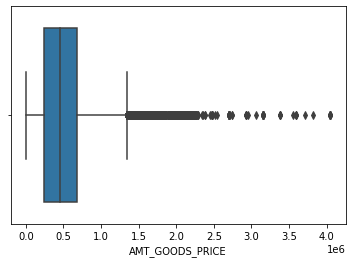

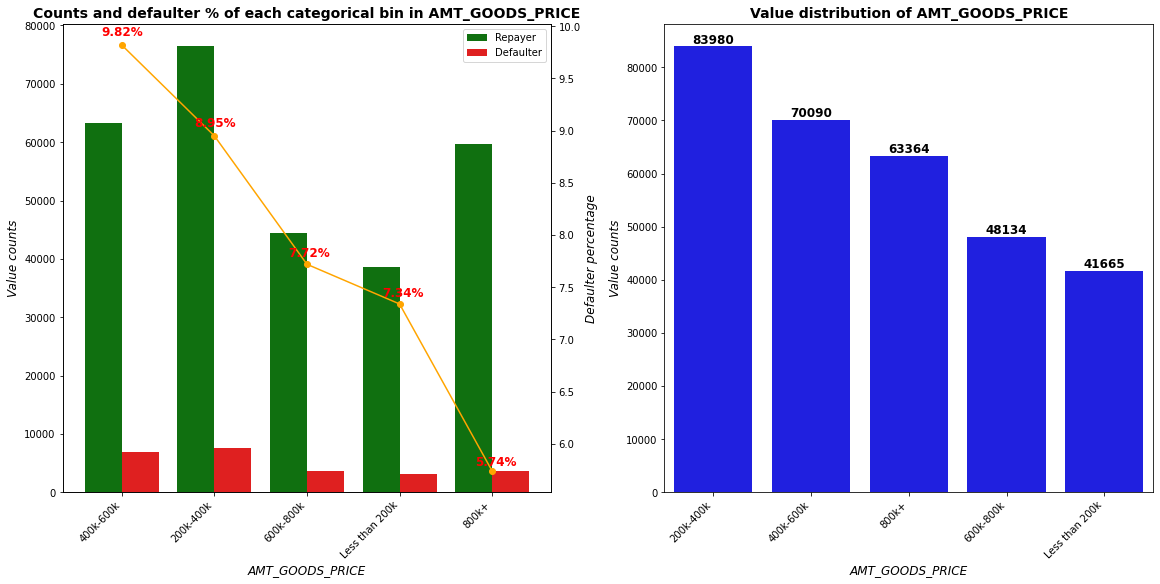

Here are the tatistical results:
  AMT_GOODS_PRICE  Defaulter_pct  Defaulter_count  Total_count
0       400k-600k           9.82             6880        70090
1       200k-400k           8.95             7513        83980
2       600k-800k           7.72             3715        48134
3  Less than 200k           7.34             3060        41665
4           800k+           5.74             3636        63364


In [ ]:
# AMT_GOODS_PRICE
box_plot("AMT_GOODS_PRICE")
bins_GOODS_PRICE = [0, 200000, 400000, 600000, 800000, application_cleaned['AMT_GOODS_PRICE'].max()]
labels_GOODS_PRICE = ['Less than 200k', '200k-400k', '400k-600k', '600k-800k', '800k+']
bin_numeric_column('AMT_GOODS_PRICE', labels=labels_GOODS_PRICE, bins=bins_GOODS_PRICE, bin_num=len(labels_GOODS_PRICE), 
                   add_label=True)
client_labels_comparsion_chart(feature='AMT_GOODS_PRICE',figsize=(16,8),rotate=True)

In [ ]:
# Applied the K-modes for clustering loan defaulter and summerize their character
# Select the loan defaulter data
defaulter_df = application_cleaned[application_cleaned['TARGET'] == 1]
print(defaulter_df.shape)
# Select features relevant to user profiling
profiling_feature_list = ['CODE_GENDER','AMT_INCOME_TOTAL','AMT_CREDIT','NAME_INCOME_TYPE',
                          'NAME_EDUCATION_TYPE','YEARS_BIRTH','YEARS_EMPLOYED','OCCUPATION_TYPE',
                          'ORGANIZATION_TYPE', 'CNT_CHILDREN','NAME_TYPE_SUITE','NAME_FAMILY_STATUS',
                          'NAME_HOUSING_TYPE','CNT_FAM_MEMBERS','FLAG_OWN_CAR','FLAG_OWN_REALTY',
                          'OWN_CAR_AGE','REGION_RATING_CLIENT_W_CITY','NAME_CONTRACT_TYPE',
                          'AMT_ANNUITY','AMT_GOODS_PRICE']
defaulter_profiling_df = defaulter_df[profiling_feature_list]
print(defaulter_profiling_df.info())
print(defaulter_profiling_df.isnull().any())

(24825, 122)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24825 entries, 0 to 307509
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   CODE_GENDER                  24825 non-null  object  
 1   AMT_INCOME_TOTAL             24825 non-null  category
 2   AMT_CREDIT                   24825 non-null  category
 3   NAME_INCOME_TYPE             24825 non-null  object  
 4   NAME_EDUCATION_TYPE          24825 non-null  object  
 5   YEARS_BIRTH                  24825 non-null  category
 6   YEARS_EMPLOYED               24825 non-null  category
 7   OCCUPATION_TYPE              24825 non-null  object  
 8   ORGANIZATION_TYPE            24825 non-null  object  
 9   CNT_CHILDREN                 24825 non-null  category
 10  NAME_TYPE_SUITE              24825 non-null  object  
 11  NAME_FAMILY_STATUS           24825 non-null  object  
 12  NAME_HOUSING_TYPE            24825 non-null  o

In [ ]:
cat_col = defaulter_profiling_df.select_dtypes(include=['category']).columns.values
print(cat_col)
for column in cat_col:
    defaulter_profiling_df = defaulter_profiling_df.astype({column:'object'})
    
# Double check the dataframe and ensure there is no NaN value in it.
print(defaulter_profiling_df.info())
defaulter_profiling_df.fillna('Unknown', inplace=True)
print(defaulter_profiling_df.head())

['AMT_INCOME_TOTAL' 'AMT_CREDIT' 'YEARS_BIRTH' 'YEARS_EMPLOYED'
 'CNT_CHILDREN' 'CNT_FAM_MEMBERS' 'OWN_CAR_AGE' 'AMT_ANNUITY'
 'AMT_GOODS_PRICE']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24825 entries, 0 to 307509
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   CODE_GENDER                  24825 non-null  object
 1   AMT_INCOME_TOTAL             24825 non-null  object
 2   AMT_CREDIT                   24825 non-null  object
 3   NAME_INCOME_TYPE             24825 non-null  object
 4   NAME_EDUCATION_TYPE          24825 non-null  object
 5   YEARS_BIRTH                  24825 non-null  object
 6   YEARS_EMPLOYED               24825 non-null  object
 7   OCCUPATION_TYPE              24825 non-null  object
 8   ORGANIZATION_TYPE            24825 non-null  object
 9   CNT_CHILDREN                 24825 non-null  object
 10  NAME_TYPE_SUITE              24825 non-null  object
 11

213652.0
210179.0
205531.0
198286.0
196612.0
194289.0
193025.0
Finish!


Text(0.5, 1.0, 'Elbow Method For Optimal k')

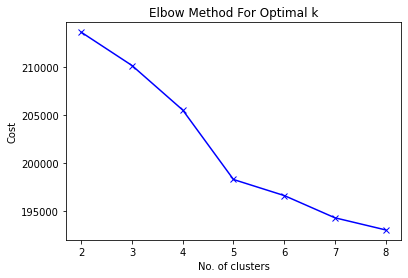

In [ ]:
cost = []
n_list = range(2, 9)
for n in n_list:
    km = kmodes.KModes(n_clusters=n, n_init=30, random_state=1, n_jobs=-1)
    km.fit(defaulter_profiling_df)
    clusters = km.predict(defaulter_profiling_df)
    cost.append(km.cost_)
    print(km.cost_)
print('Finish!')

plt.plot(n_list, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')

In [ ]:
# Redo the classification process via k_mode and set the n_cluster to 5.
km_5c = kmodes.KModes(n_clusters=5, n_init=30)
km_5c.fit(defaulter_profiling_df)
clusters_5c = km_5c.predict(defaulter_profiling_df)
print(km_5c.cost_)

198286.0


In [ ]:
print(pd.Series(clusters_5c).isna().any())

False


In [ ]:
# Apply the pca method to reduce the demension.

# Transform all the categorical value to numeric codes so we can apply pca method on the dataset
temp_df = defaulter_profiling_df.copy()
for col_name in temp_df.select_dtypes('object').columns.values:
    value_list = temp_df[col_name].unique()
    for index, value in enumerate(value_list):
        temp_df[col_name].replace(value, index, inplace=True)

print(temp_df.head()) 

pca = PCA()
pca.fit(temp_df)
pca_samples = pca.transform(temp_df)
variance_ratio = pca.explained_variance_ratio_

print('explained_variance_ratio_:{}'.format(pca.explained_variance_ratio_))

    CODE_GENDER  AMT_INCOME_TOTAL  AMT_CREDIT  NAME_INCOME_TYPE  \
0             0                 0           0                 0   
26            1                 1           1                 0   
40            0                 0           2                 1   
42            1                 1           0                 0   
81            1                 2           0                 2   

    NAME_EDUCATION_TYPE  YEARS_BIRTH  YEARS_EMPLOYED  OCCUPATION_TYPE  \
0                     0            0               0                0   
26                    0            1               1                1   
40                    0            2               2                0   
42                    0            3               1                2   
81                    0            4               0                3   

    ORGANIZATION_TYPE  CNT_CHILDREN  ...  NAME_FAMILY_STATUS  \
0                   0             0  ...                   0   
26                  0         

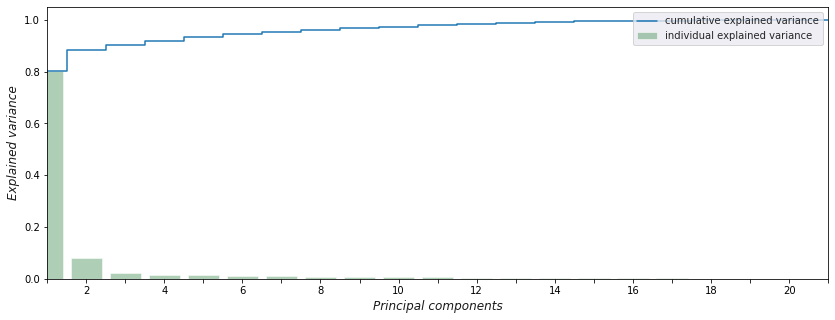

In [ ]:
# Visualize the explained_variance_ratio
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(temp_df.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,temp_df.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 20)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', **content_font)
plt.xlabel('Principal components', **content_font)
plt.legend(loc='upper right', fontsize = 10)

198286.0
[0.80182561 0.0808878 ]
               0         1  cluster
0      -9.294872 -3.678039        1
1      -9.247458 -2.693181        0
2      -9.267343 -3.699523        2
3      -8.220161 -1.753156        0
4      -7.213746 -0.796289        0
...          ...       ...      ...
24820  -9.251375 -3.709884        2
24821  -3.270832 -3.904118        2
24822  -9.143260  0.296715        0
24823  -9.230812 -1.719104        0
24824  12.744928 -4.421147        0

[24825 rows x 3 columns]


<AxesSubplot: xlabel='0', ylabel='1'>

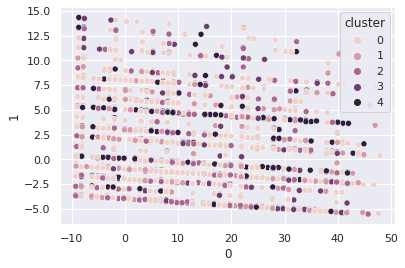

In [ ]:
# Reduce dimension to 2.
pca_2 = PCA(n_components=2)
defaulter_2d = pca_2.fit_transform(temp_df)
variance_ratio = pca_2.explained_variance_ratio_
print(km_5c.cost_)
defaulter_2d_df = pd.DataFrame(defaulter_2d)
defaulter_2d_df['cluster'] = pd.Series(clusters_5c)
print(variance_ratio)
print(defaulter_2d_df)

# plot the 2d scatter plot
plt.figsize=(20,12)
sns.scatterplot(data=defaulter_2d_df, x=0, y=1,hue='cluster')

In [ ]:
# add the clustering label on the defaulter_profiling dataset
defaulter_profiling_df['REGION_RATING_CLIENT_W_CITY'] = defaulter_profiling_df['REGION_RATING_CLIENT_W_CITY']. \
    astype('object')
defaulter_dummies = pd.get_dummies(defaulter_profiling_df)
defaulter_dummies['label'] = pd.Series(clusters_5c, index=defaulter_profiling_df.index.values)

In [ ]:
# Here, I will set up a threshold value to filter characteristics. Only characteristics with more than 70% can be the 
# 'label' of the cluster.
def visualize_common_feature(thershold=0.7, label=0):
    visualization_data = defaulter_dummies[defaulter_dummies['label'] == label]
    visualization_data = visualization_data.drop('label', axis=1)
    
    feature_pct = visualization_data.mean(axis=0).sort_values(ascending=True)
    if ((thershold < 1) & (thershold > 0)): 
        prominent_features = feature_pct[feature_pct>thershold]
        print(prominent_features)
    else:
        print('Please set the thershold value from 0 to 1')
    
    if len(prominent_features) > 10:
        prominent_features = prominent_features[0:10]
    
    prominent_features.plot.barh()

FLAG_OWN_REALTY_Y                                    0.718263
REGION_RATING_CLIENT_W_CITY_2                        0.737148
CODE_GENDER_F                                        0.738520
CNT_CHILDREN_No child                                0.781777
NAME_EDUCATION_TYPE_Secondary / secondary special    0.795900
NAME_TYPE_SUITE_Unaccompanied                        0.813574
OWN_CAR_AGE_Unknown                                  0.815753
FLAG_OWN_CAR_N                                       0.815753
NAME_HOUSING_TYPE_House / apartment                  0.869421
NAME_CONTRACT_TYPE_Cash loans                        0.928739
dtype: float64


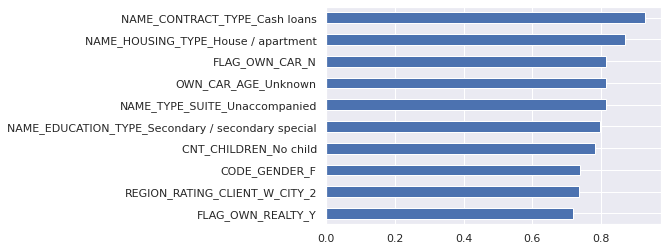

In [ ]:
# Visualize the top 10 characteristics for cluster 0 
visualize_common_feature(label=0)

REGION_RATING_CLIENT_W_CITY_2                        0.715019
OWN_CAR_AGE_Unknown                                  0.732991
FLAG_OWN_CAR_N                                       0.732991
NAME_HOUSING_TYPE_House / apartment                  0.754557
NAME_EDUCATION_TYPE_Secondary / secondary special    0.765083
NAME_TYPE_SUITE_Unaccompanied                        0.874454
CNT_CHILDREN_No child                                0.883697
NAME_CONTRACT_TYPE_Cash loans                        0.955584
dtype: float64


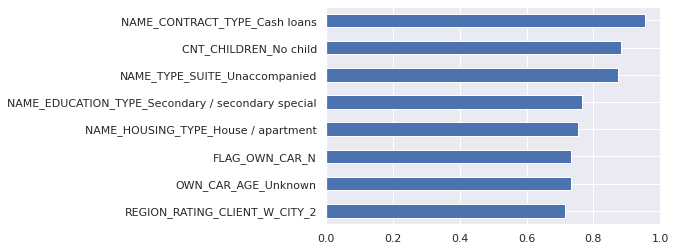

In [ ]:
# Visualize the top 10 characteristics for cluster 1
visualize_common_feature(label=1)

NAME_INCOME_TYPE_Working                             0.711404
REGION_RATING_CLIENT_W_CITY_2                        0.724293
CNT_CHILDREN_1 child                                 0.726534
FLAG_OWN_REALTY_Y                                    0.768282
NAME_TYPE_SUITE_Unaccompanied                        0.801345
NAME_EDUCATION_TYPE_Secondary / secondary special    0.803026
NAME_FAMILY_STATUS_Married                           0.814234
NAME_HOUSING_TYPE_House / apartment                  0.887083
NAME_CONTRACT_TYPE_Cash loans                        0.963575
dtype: float64


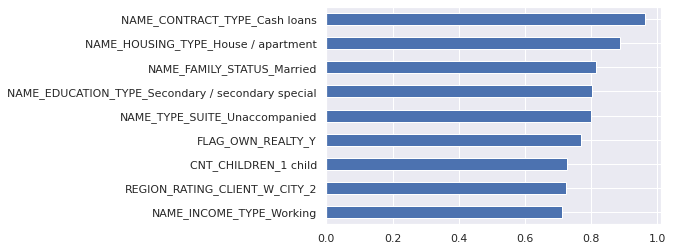

In [ ]:
# Visualize the top 10 characteristics for cluster 2 
visualize_common_feature(label=2)

NAME_INCOME_TYPE_Working                             0.740302
REGION_RATING_CLIENT_W_CITY_2                        0.741379
FLAG_OWN_REALTY_Y                                    0.758621
NAME_TYPE_SUITE_Unaccompanied                        0.799569
OWN_CAR_AGE_Unknown                                  0.802263
FLAG_OWN_CAR_N                                       0.802263
NAME_CONTRACT_TYPE_Cash loans                        0.811961
CODE_GENDER_F                                        0.813578
NAME_EDUCATION_TYPE_Secondary / secondary special    0.827586
NAME_HOUSING_TYPE_House / apartment                  0.843211
dtype: float64


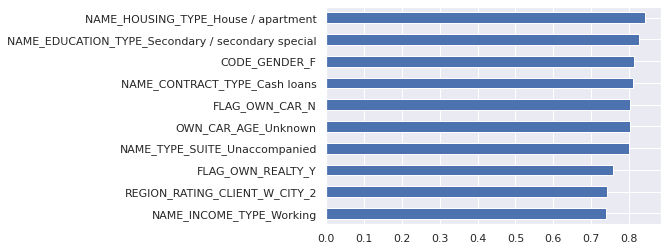

In [ ]:
# Visualize the top 10 characteristics for cluster 3
visualize_common_feature(label=3)

CNT_FAM_MEMBERS_2 members                            0.714194
CODE_GENDER_M                                        0.722543
NAME_EDUCATION_TYPE_Secondary / secondary special    0.732177
REGION_RATING_CLIENT_W_CITY_2                        0.735389
FLAG_OWN_REALTY_Y                                    0.752087
NAME_FAMILY_STATUS_Married                           0.770392
CNT_CHILDREN_No child                                0.786769
NAME_TYPE_SUITE_Unaccompanied                        0.804753
FLAG_OWN_CAR_Y                                       0.834618
NAME_HOUSING_TYPE_House / apartment                  0.908478
NAME_CONTRACT_TYPE_Cash loans                        0.977842
dtype: float64


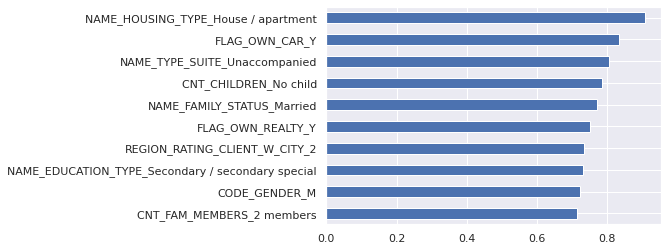

In [ ]:
# Visualize the top 10 characteristics for cluster 4
visualize_common_feature(label=4)

NAME_CONTRACT_TYPE_Cash loans                        0.935388
NAME_HOUSING_TYPE_House / apartment                  0.856878
NAME_TYPE_SUITE_Unaccompanied                        0.819215
NAME_EDUCATION_TYPE_Secondary / secondary special    0.786465
REGION_RATING_CLIENT_W_CITY_2                        0.731923
                                                       ...   
NAME_EDUCATION_TYPE_Academic degree                  0.000121
ORGANIZATION_TYPE_Industry: type 8                   0.000121
ORGANIZATION_TYPE_Trade: type 5                      0.000121
ORGANIZATION_TYPE_Trade: type 4                      0.000081
NAME_INCOME_TYPE_Maternity leave                     0.000081
Length: 171, dtype: float64


<AxesSubplot: >

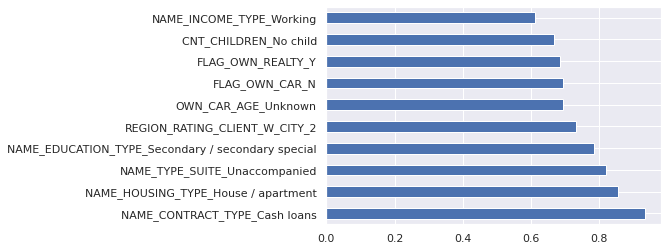

In [ ]:
feature_summary_pct = defaulter_dummies.mean(axis=0).sort_values(ascending=False)
feature_summary_pct.drop('label', inplace=True)
print(feature_summary_pct)
feature_summary_pct[0:10].plot.barh()

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    # Parameters:
    # 1、 estimator - prediction model object
    # 2、 title - The title of the diagram
    # 3、 X - training dataset
    # 4、 y - label dataset
    # 5、 ylim - the range of y axis
    # 6、 cv - the number of cross-validation
    # 7、 training_sizes - the pct of the total training samples
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # mean and std score of both train and test dataset
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    # Detail setting
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
# Split the train_df
features_df = train_df.drop('TARGET', axis=1)
labels_df = train_df['TARGET']
train_dummies = pd.get_dummies(features_df)

X_train, X_test, Y_train, Y_test = train_test_split(train_dummies, labels_df, random_state=1)
print('The spliting process has finished!')


# build the pipeline for random forest
rfc_model = RandomForestClassifier(random_state=1, max_depth=3)
select_rfc = SelectFromModel(rfc_model, threshold="median")
para_grid = [{'feature_selection': [select_rfc], 
              'classifier__n_estimators': np.arange(50, 150, 10)}]
pipe = Pipeline([('feature_selection', select_rfc), ('classifier', rfc_model)])
grid = GridSearchCV(pipe, param_grid=para_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid.fit(X_train, Y_train)
best_model = grid.best_estimator_
best_score = grid.best_score_
print(best_model)
print(best_score)

The spliting process has finished!
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(max_depth=3,
                                                                  random_state=1),
                                 threshold='median')),
                ('classifier',
                 RandomForestClassifier(max_depth=3, n_estimators=120,
                                        random_state=1))])
0.7033202460835377


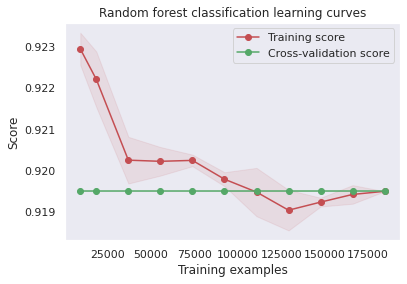

In [ ]:
# plot learning curve and evaluate the performance of the best rfm setting
rfc_best = RandomForestClassifier(n_estimators=120, max_depth=3, random_state=1)
rfc_learning_curve = plot_learning_curve(rfc_best, "Random forest classification learning curves", 
                                         X_train, Y_train, cv = 5, 
                                         train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [ ]:
# test the prediction performance using the X-train dataset
rfc_best.fit(X_train, Y_train)
Y_predict = rfc_best.predict_proba(X_test)[:,1]
print(Y_predict)
print(rfc_best.classes_)
print(roc_auc_score(Y_test, Y_predict))

[0.06415442 0.09483616 0.08829253 ... 0.08948133 0.06426616 0.07304601]
[0 1]
0.7093644114303688


In [ ]:
# Print out the ro curve for reference
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
result = pd.DataFrame([thresholds,tpr,fpr], index= ['threshold','TPR','FPR']) 
print(result)

              0         1         2         3         4         5      \
threshold  1.139553  0.139553  0.138082  0.138060  0.137671  0.137311   
TPR        0.000000  0.000000  0.000000  0.000160  0.000160  0.000479   
FPR        0.000000  0.000014  0.000028  0.000028  0.000042  0.000042   

              6         7         8         9      ...     11251     11252  \
threshold  0.136927  0.136058  0.136041  0.135932  ...  0.049042  0.048570   
TPR        0.000479  0.000799  0.000799  0.001118  ...  0.999361  0.999361   
FPR        0.000057  0.000057  0.000071  0.000071  ...  0.995171  0.996191   

              11253     11254     11255     11256     11257     11258  \
threshold  0.048567  0.048354  0.048332  0.048078  0.048060  0.047737   
TPR        0.999521  0.999521  0.999681  0.999681  0.999840  0.999840   
FPR        0.996191  0.996616  0.996616  0.996984  0.996984  0.997451   

              11259     11260  
threshold  0.047731  0.040998  
TPR        1.000000  1.000000  
FPR  

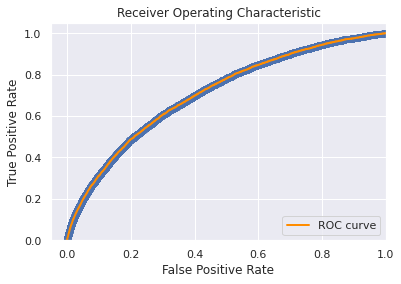

In [ ]:
plt.figure() 
plt.scatter(fpr, tpr) 
# plot the roc curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve') 
plt.xlim([-0.05, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver Operating Characteristic') 
plt.legend(loc="lower right") 

In [ ]:
# print out the feature importance
feature_importance_df = pd.DataFrame(data=rfc_best.feature_importances_, index=rfc_best.feature_names_in_)
feature_importance_df.sort_values(0, ascending=False, inplace=True)
print(feature_importance_df)

                                              0
EXT_SOURCE_2                           0.181941
EXT_SOURCE_3                           0.135399
EXT_SOURCE_1                           0.073067
YEARS_BIRTH                            0.058044
YEARS_EMPLOYED                         0.037148
...                                         ...
NAME_HOUSING_TYPE_Co-op apartment      0.000000
NAME_HOUSING_TYPE_Municipal apartment  0.000000
NAME_HOUSING_TYPE_Office apartment     0.000000
NAME_HOUSING_TYPE_Rented apartment     0.000000
SK_ID_CURR                             0.000000

[251 rows x 1 columns]
